In [257]:
import numpy as np
import scipy as sp
import scipy.signal as signal
import sympy as sym

from scipy.io import wavfile

import matplotlib.pyplot as plt

from tqdm import tqdm

import utils

from ICA_functions import get_g_dg_d2g_over_dg, calc_h, calc_grad_W

In [258]:
np.random.seed(0) 
PLAY_AUDIO = True

In [259]:
mat_filename = './experiment_0/chirp_gong.mat'
signal_mat = sp.io.loadmat(mat_filename)
s, Fs = signal_mat['s'], signal_mat['Fs'][0, 0]

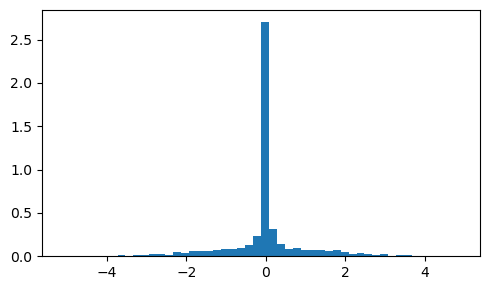

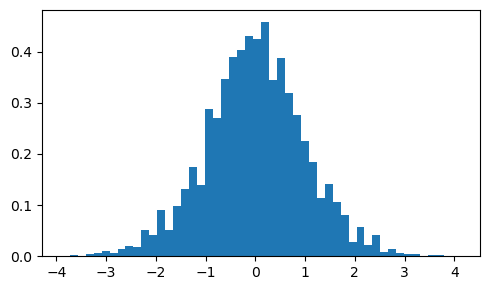

In [260]:
for i in range(s.shape[0]):
    plt.figure(figsize=(5, 3))
    plt.hist(s[i, :], bins=50, density=True)
    plt.tight_layout()
    plt.show()

In [261]:
if PLAY_AUDIO:
    utils.play_audios(s, Fs, norm_coef=0.1)

In [262]:
N = s.shape[0]  # number of source signals
M = N           # number of sensors (M=N)
T = s.shape[1]  # number of time samples (measurements)

W0 = np.eye(N, M, dtype=np.float64)  # unmixing initialization

sym_g = sym.tanh  # assumtion for signals' cdf (must be sympy function) 

g, dg, d2g_over_dg = get_g_dg_d2g_over_dg(sym_g)  # automatic symbolic g''/g' calculation with conversion to numpy

maxiter = 1000 #1000

lr = 0.5 #0.1 # 0.3  # it's good for 3

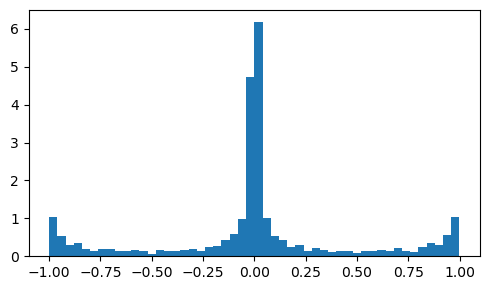

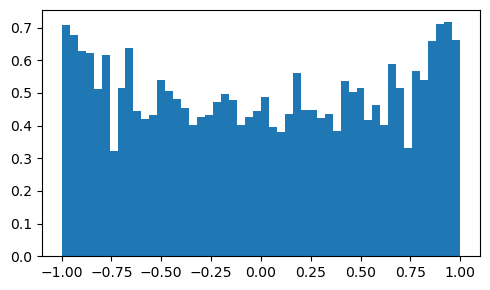

In [263]:
for i in range(s.shape[0]):
    plt.figure(figsize=(5, 3))
    plt.hist(g(s[i, :]), bins=50, density=True)
    plt.tight_layout()
    plt.show()

In [264]:
#A = np.abs(np.random.randn(M, N))     # mixing matrix generation

In [265]:
A = np.array([
    [1, 0.3],
    [-0.4, 0.7]
])

# A = np.array([
#     [1, 1],
#     [-0.4, 0.7]
# ])

np.linalg.cond(A)

1.4154741915548452

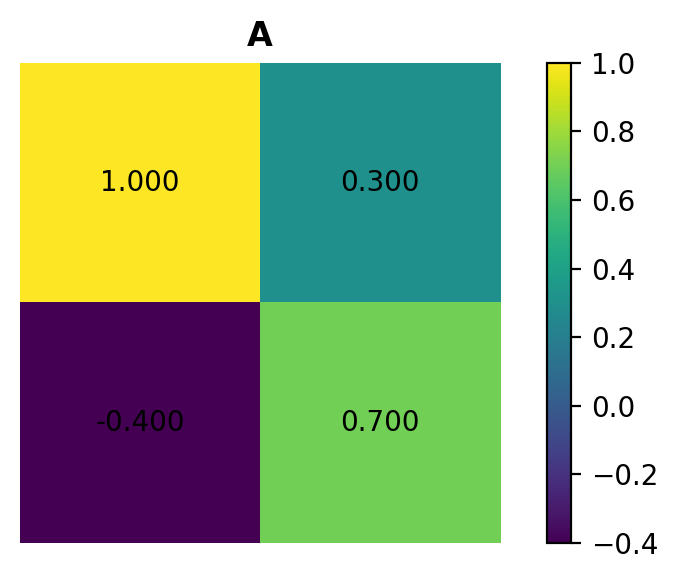

In [266]:
utils.plot_matrix(A, f'$\mathbf{{A}}$')

In [267]:
x = A @ s

W = W0.copy()
y = W @ x

In [268]:
# x = np.einsum('cn,c->cn', x, 1/np.mean(x**2, axis=-1))

In [269]:
np.mean(s**2), np.mean(x**2), np.mean(y**2)

(0.9999266520658401, 0.8699700921273333, 0.8699700921273333)

In [270]:
if PLAY_AUDIO:
    utils.play_audios(x, Fs, norm_coef=0.1)

In [271]:
h_log = np.zeros(maxiter)
grad_norm_log = np.zeros(maxiter)

In [272]:
pbar = tqdm(range(maxiter))
for it in pbar:
    y = W @ x
    
    h = calc_h(T, dg(y), W)
    
    grad_W = calc_grad_W(T, x, d2g_over_dg(y), W)
    
    W += lr * grad_W
    
    
    h_log[it] = h
    grad_norm_log[it] = np.linalg.norm(grad_W, ord=2)
    
    if it%20 == 0:
        pbar.set_postfix({'grad_norm' : f"{grad_norm_log[it]:.3g}",
                        'h' : f"{h_log[it]:.3g}"})

100%|██████████| 1000/1000 [00:01<00:00, 650.75it/s, grad_norm=1.42e-16, h=-1.12]


In [273]:
y = W @ x

Rescale the signals

In [274]:
# y = np.einsum('cn,c->cn', y, 1/np.max(np.abs(y), axis=-1))
y = np.einsum('cn,c->cn', y, 1/np.sqrt(np.mean(y**2, axis=-1)))

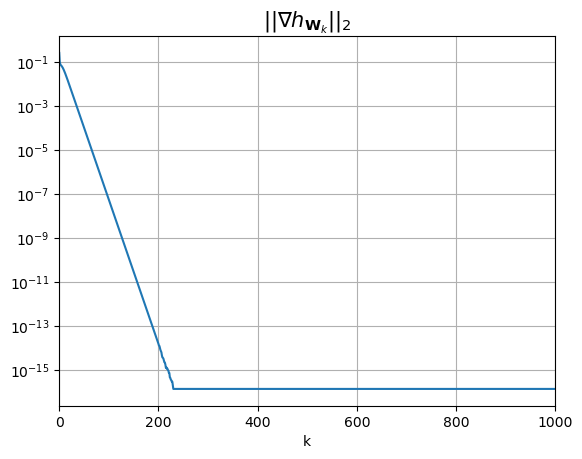

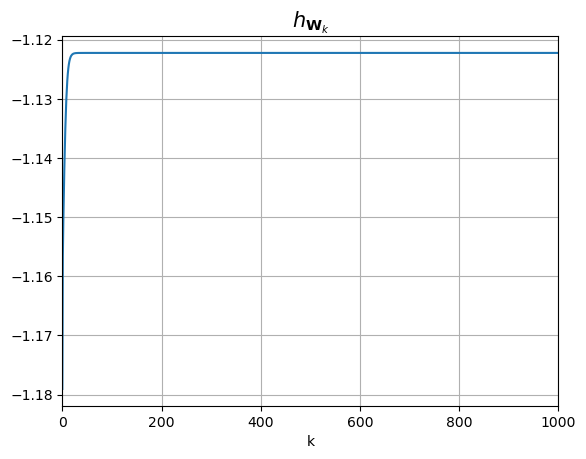

In [285]:
plt.figure()
plt.title(r'$ ||\nabla h_{\mathbf{W}_k}||_{2} $', fontsize=15)
plt.semilogy(grad_norm_log)
plt.xlim([0, maxiter])
plt.grid()
plt.xlabel('k')
plt.show()

plt.figure()
plt.title(r'$h_{\mathbf{W}_k}$', fontsize=15)
plt.plot(h_log)
plt.xlim([0, maxiter])
plt.grid()
plt.xlabel('k')
plt.show()

In [ ]:
if PLAY_AUDIO:
    utils.play_audios(y, Fs, norm_coef=0.1)

In [ ]:
np.mean(y**2), np.mean(x**2), np.mean(s**2)

(1.0, 0.8699700921273333, 0.9999266520658401)

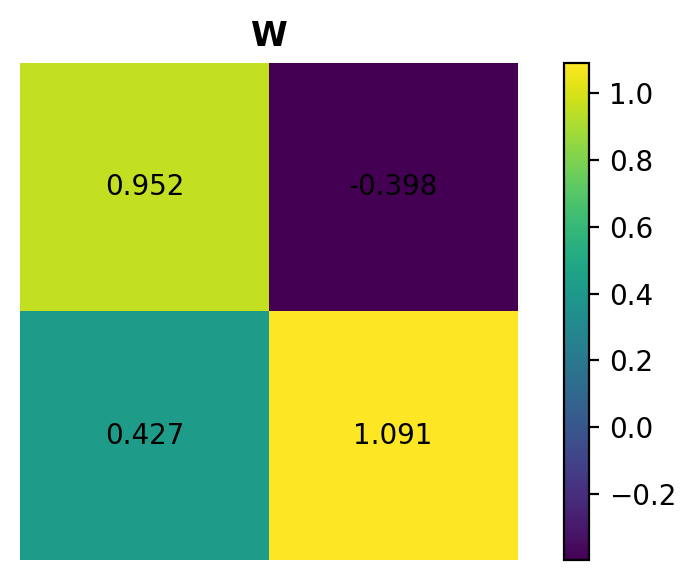

In [ ]:
utils.plot_matrix(W, f'$\mathbf{{W}}$')

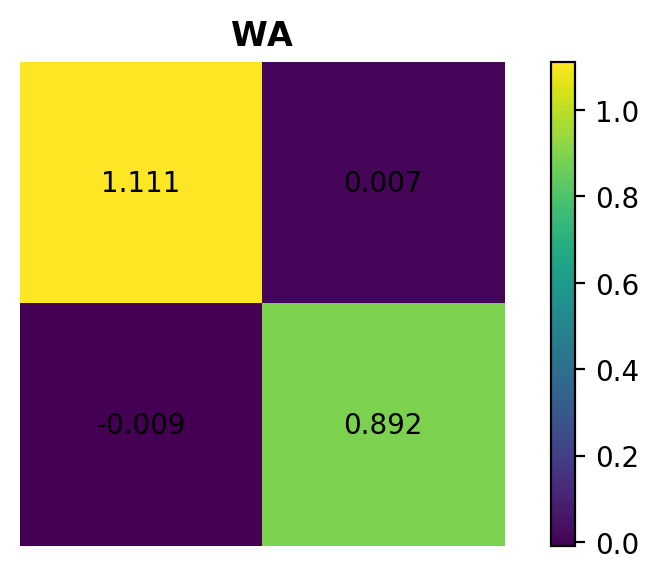

In [ ]:
utils.plot_matrix(W@A, f'$\mathbf{{W}}\mathbf{{A}}$')